In [13]:
import sys
from pathlib import Path
sys.path.append(str(Path.cwd().parent))
import pandas as pd

from scripts.importing import import_data

from scripts.cleaning import group

from prophet import Prophet
from prophet.plot import add_changepoints_to_plot
from sklearn.metrics import mean_squared_error, mean_absolute_error
from math import sqrt
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [14]:
# HYPER
AREA = 'NORAME'
RELEASE = 'N1'


In [15]:
df = import_data()


importing data...
end


In [16]:
df.year_release.unique()

array(['2023 N1', '2024 N1', '2022 N2', '2023 N2', '2022 FW', '2022 SS',
       '2022 N1', '2023 SS', '2021 FW', '2021 M1', '2021 AD', '2021 SS',
       '2020 AD', '2020 M1', '2020 SS', '2019 AD', '2019 M2', '2019 SS'],
      dtype=object)

In [17]:

# Function to convert YYYYWW to datetime
def yearweek_to_datetime(yearweek_str):
    yearweek_str = str(yearweek_str)
    year = yearweek_str[:4]
    week = yearweek_str[4:]
    # Parse the year and week and combine it with '0' for Monday
    datetime_str = f'{year} {week} 0'
    # Convert to datetime object, %U is week number of the year, Sunday as the first day of week, 00-53
    # %w is the day of the week, with Sunday as 0
    return pd.to_datetime(datetime_str, format='%Y %U %w')

def filter_dates(row):
    # Extract the year and convert to integer
    year = int(row['year_release'][:4])
    
    if row['release'] == 'N1':
        # Define the start and end dates for the range
        start_date = pd.Timestamp(year=year-1, month=11, day=1)
        end_date = pd.Timestamp(year=year, month=10, day=31)

    elif row['release'] == 'N2':
        start_date = pd.Timestamp(year=year, month=7, day=1)
        end_date = pd.Timestamp(year=year+1, month=6, day=30)
    
    # Check if the year_week is within the range
    return start_date <= row['year_week'] <= end_date


    # Function to calculate SMAPE
def smape(y_true, y_pred): 
    return 100 / len(y_true) * np.sum(2 * np.abs(y_pred - y_true) / (np.abs(y_true) + np.abs(y_pred)))

def wmape(y_true, y_pred):
    return 100*(np.sum(np.abs(y_pred - y_true)) / np.sum((np.abs(y_true))))



In [18]:
df_temp = df.groupby(by = ['year_week', 'exit', 'brand', 'area_dedalo', 'year_release'], as_index=False)['order_quantity'].sum()

In [19]:
dict_rel = {
    'AD': 'N1',
    'M1': 'N2',
    'M2': 'SS'
}

df_temp['year_release'] = df_temp['year_release'].replace(dict_rel, regex=True)
df_temp['release'] = df_temp['year_release'].str[-2:]

********************
RB
NORAME
N1
********************


/var/folders/4n/7zm_f9b959gbsyh_5ld2nw_80000gn/T/ipykernel_4598/3979170457.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_trial['year_week'] = df_trial['year_week'].apply(yearweek_to_datetime)


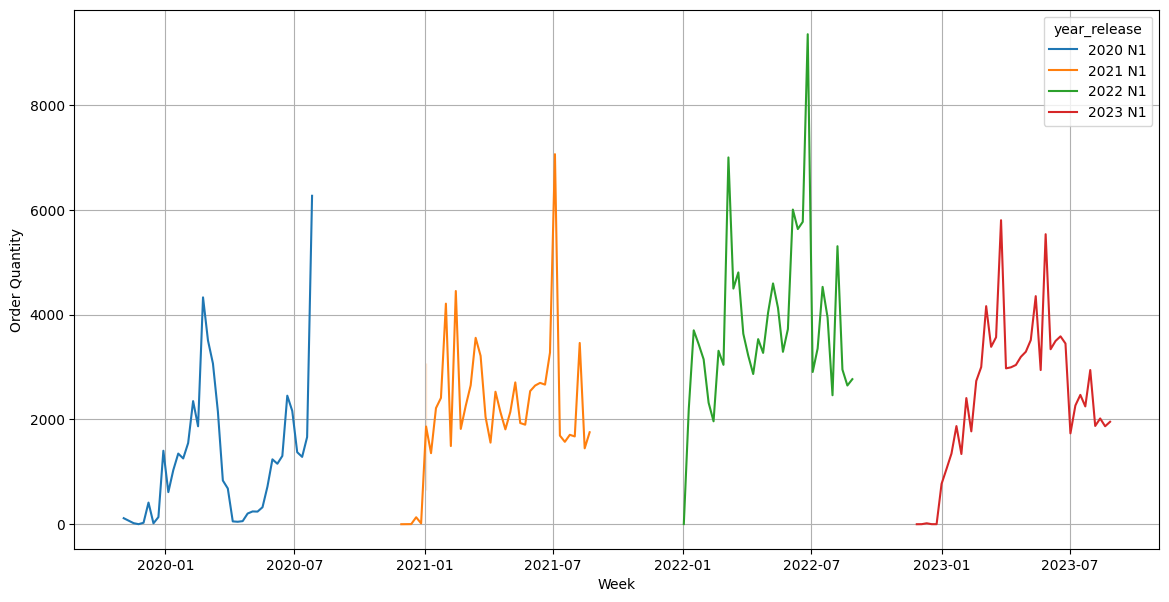

22:39:23 - cmdstanpy - INFO - Chain [1] start processing
22:39:23 - cmdstanpy - INFO - Chain [1] done processing
/Users/mottad/Library/CloudStorage/OneDrive-LuxotticaGroupS.p.A/Desktop/tesi_tommy/.venv/lib/python3.11/site-packages/prophet/plot.py:72: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  fcst_t = fcst['ds'].dt.to_pydatetime()
/Users/mottad/Library/CloudStorage/OneDrive-LuxotticaGroupS.p.A/Desktop/tesi_tommy/.venv/lib/python3.11/site-packages/prophet/plot.py:73: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  ax.plot(m.history['ds'].dt.to_pydatetime(), m.history['y'], 'k.',


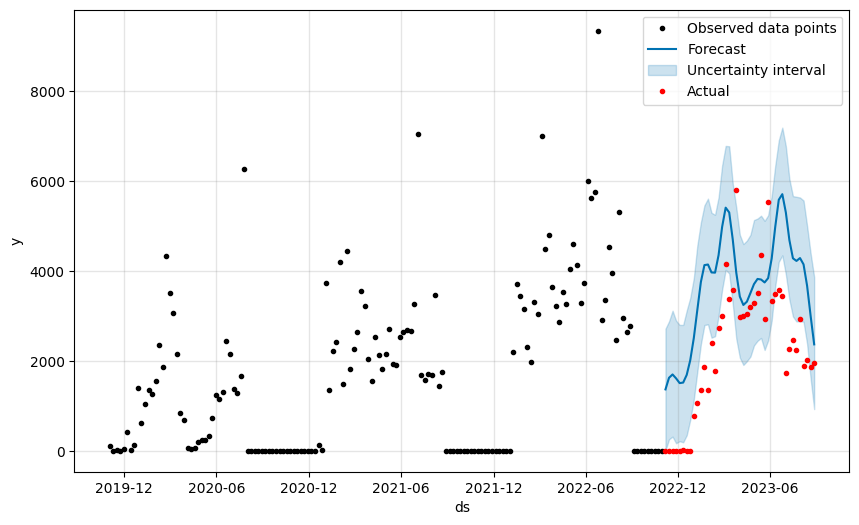

/var/folders/4n/7zm_f9b959gbsyh_5ld2nw_80000gn/T/ipykernel_4598/3979170457.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_trial['year_week'] = df_trial['year_week'].apply(yearweek_to_datetime)


Mean Absolute Error (MAE): 1538.16
Mean Squared Error (MSE): 2904826.73
Root Mean Squared Error (RMSE): 1704.36
Symmetric Mean Absolute Percentage Error (SMAPE): 75.25%
WMAPE: 67.25%
Total Aboslute Percentage Error: 58.96% 

********************
OO
NORAME
N1
********************


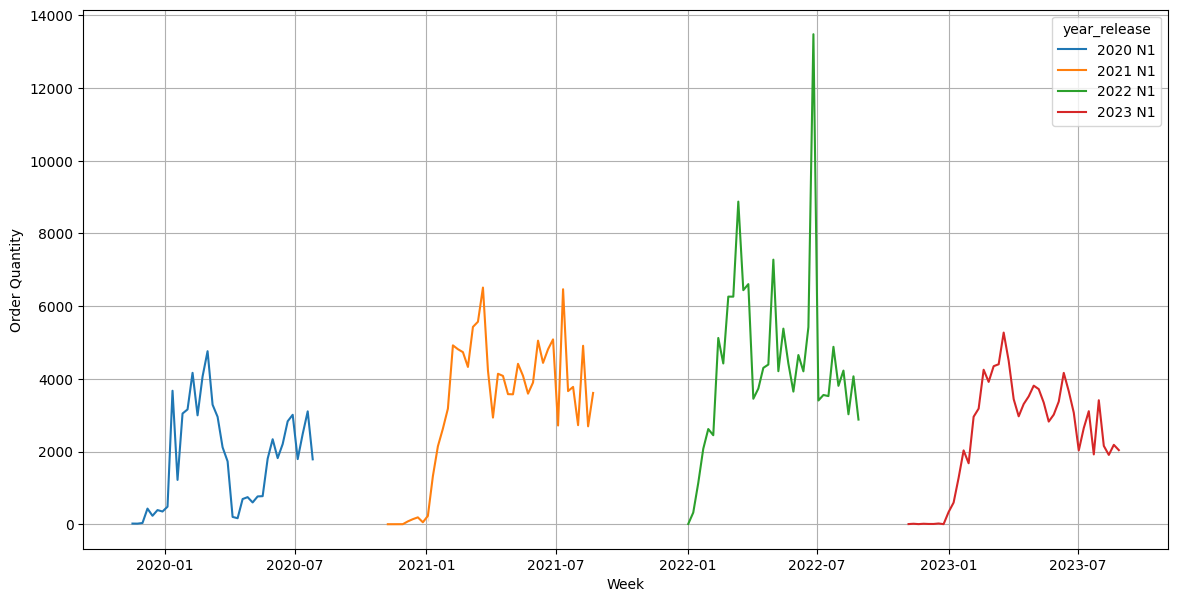

22:39:24 - cmdstanpy - INFO - Chain [1] start processing
22:39:24 - cmdstanpy - INFO - Chain [1] done processing
/Users/mottad/Library/CloudStorage/OneDrive-LuxotticaGroupS.p.A/Desktop/tesi_tommy/.venv/lib/python3.11/site-packages/prophet/plot.py:72: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  fcst_t = fcst['ds'].dt.to_pydatetime()
/Users/mottad/Library/CloudStorage/OneDrive-LuxotticaGroupS.p.A/Desktop/tesi_tommy/.venv/lib/python3.11/site-packages/prophet/plot.py:73: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  ax.plot(m.history['ds'].dt.to_pydatetime(), m.history['y'], 'k.',


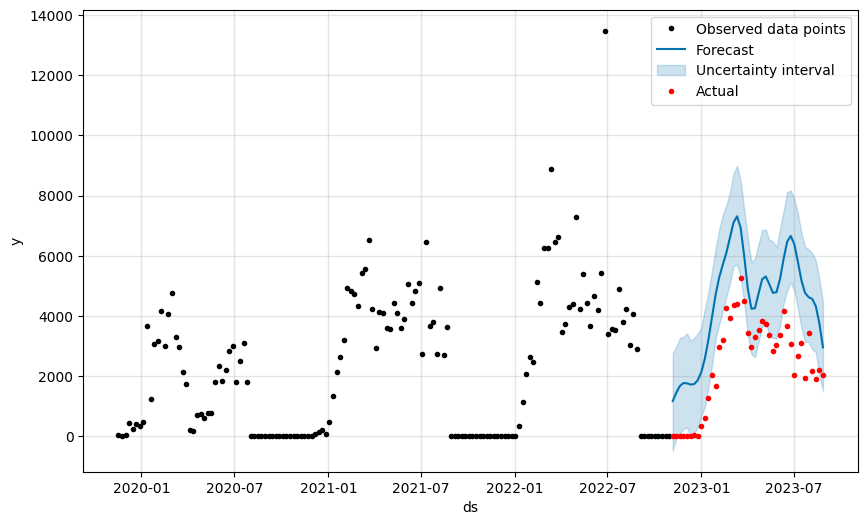

/var/folders/4n/7zm_f9b959gbsyh_5ld2nw_80000gn/T/ipykernel_4598/3979170457.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_trial['year_week'] = df_trial['year_week'].apply(yearweek_to_datetime)


Mean Absolute Error (MAE): 2000.36
Mean Squared Error (MSE): 4504025.45
Root Mean Squared Error (RMSE): 2122.27
Symmetric Mean Absolute Percentage Error (SMAPE): 82.93%
WMAPE: 82.34%
Total Aboslute Percentage Error: 82.34% 

********************
RX
NORAME
N1
********************


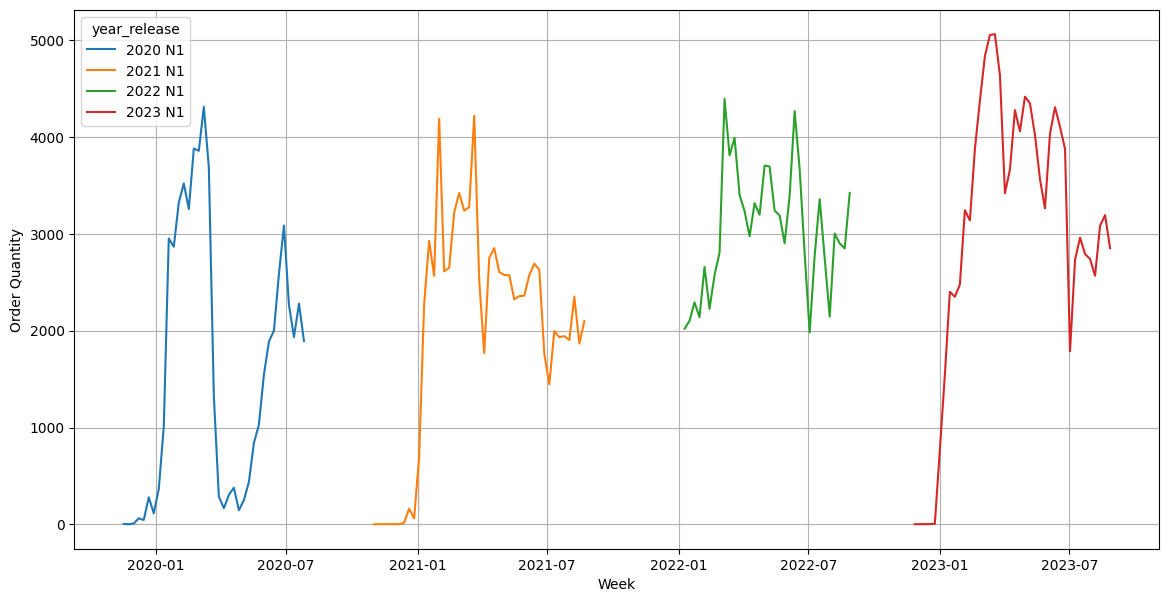

22:39:24 - cmdstanpy - INFO - Chain [1] start processing
22:39:24 - cmdstanpy - INFO - Chain [1] done processing
/Users/mottad/Library/CloudStorage/OneDrive-LuxotticaGroupS.p.A/Desktop/tesi_tommy/.venv/lib/python3.11/site-packages/prophet/plot.py:72: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  fcst_t = fcst['ds'].dt.to_pydatetime()
/Users/mottad/Library/CloudStorage/OneDrive-LuxotticaGroupS.p.A/Desktop/tesi_tommy/.venv/lib/python3.11/site-packages/prophet/plot.py:73: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  ax.plot(m.history['ds'].dt.to_pydatetime(), m.history['y'], 'k.',


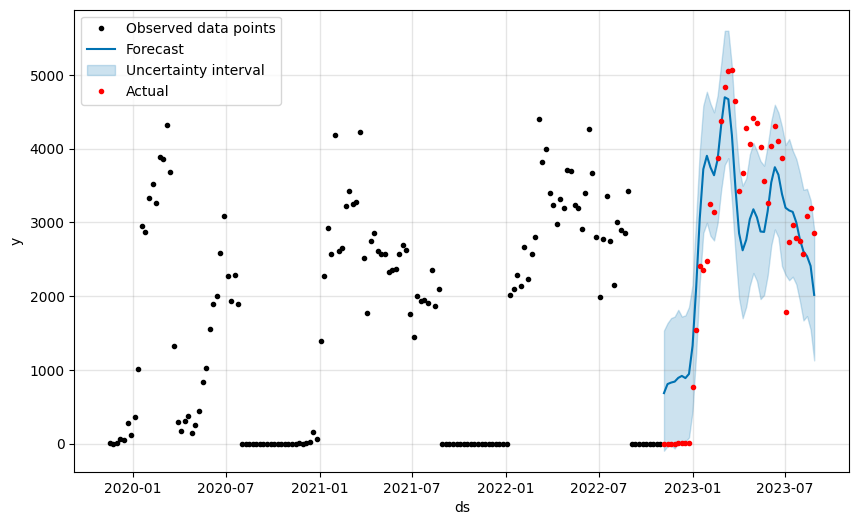

/var/folders/4n/7zm_f9b959gbsyh_5ld2nw_80000gn/T/ipykernel_4598/3979170457.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_trial['year_week'] = df_trial['year_week'].apply(yearweek_to_datetime)


Mean Absolute Error (MAE): 700.57
Mean Squared Error (MSE): 656602.11
Root Mean Squared Error (RMSE): 810.31
Symmetric Mean Absolute Percentage Error (SMAPE): 54.69%
WMAPE: 25.13%
Total Aboslute Percentage Error: 0.71% 

********************
VO
NORAME
N1
********************


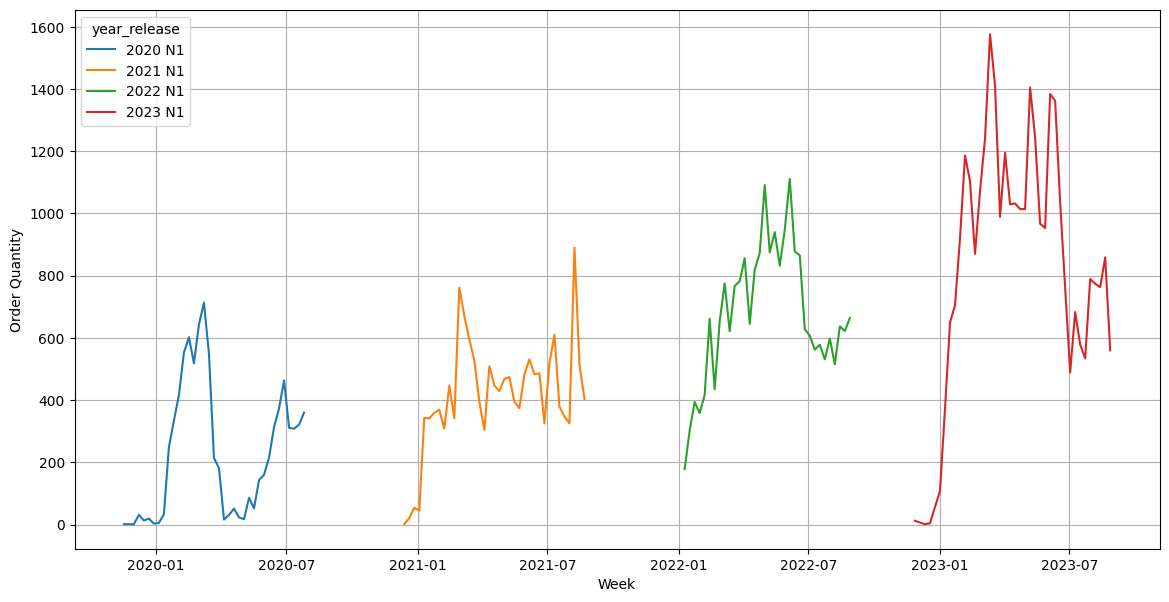

22:39:25 - cmdstanpy - INFO - Chain [1] start processing
22:39:25 - cmdstanpy - INFO - Chain [1] done processing
/Users/mottad/Library/CloudStorage/OneDrive-LuxotticaGroupS.p.A/Desktop/tesi_tommy/.venv/lib/python3.11/site-packages/prophet/plot.py:72: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  fcst_t = fcst['ds'].dt.to_pydatetime()
/Users/mottad/Library/CloudStorage/OneDrive-LuxotticaGroupS.p.A/Desktop/tesi_tommy/.venv/lib/python3.11/site-packages/prophet/plot.py:73: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  ax.plot(m.history['ds'].dt.to_pydatetime(), m.history['y'], 'k.',


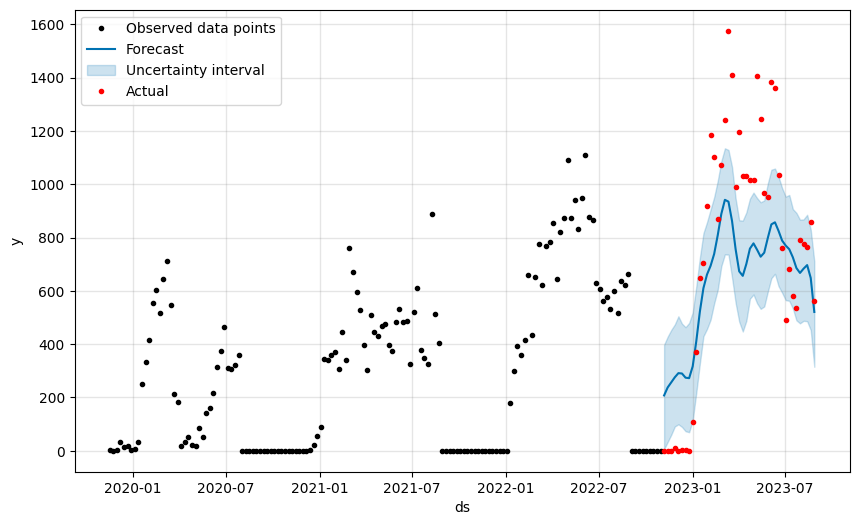

/var/folders/4n/7zm_f9b959gbsyh_5ld2nw_80000gn/T/ipykernel_4598/3979170457.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_trial['year_week'] = df_trial['year_week'].apply(yearweek_to_datetime)


Mean Absolute Error (MAE): 264.28
Mean Squared Error (MSE): 96516.07
Root Mean Squared Error (RMSE): 310.67
Symmetric Mean Absolute Percentage Error (SMAPE): 62.11%
WMAPE: 34.81%
Total Aboslute Percentage Error: 16.33% 

********************
PR
NORAME
N1
********************


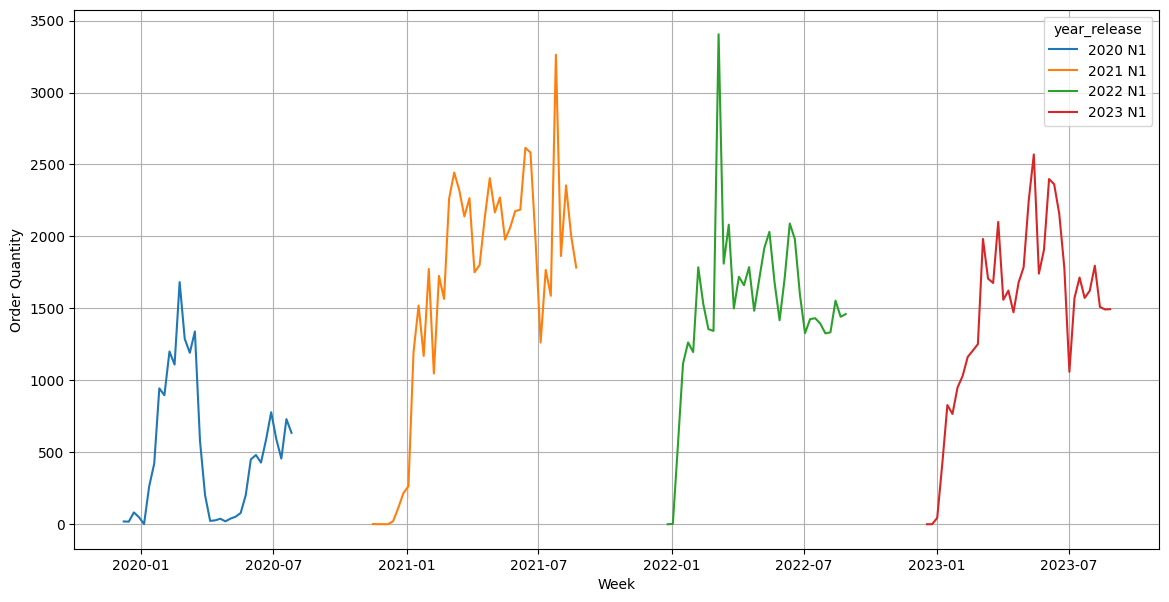

22:39:25 - cmdstanpy - INFO - Chain [1] start processing
22:39:25 - cmdstanpy - INFO - Chain [1] done processing
/Users/mottad/Library/CloudStorage/OneDrive-LuxotticaGroupS.p.A/Desktop/tesi_tommy/.venv/lib/python3.11/site-packages/prophet/plot.py:72: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  fcst_t = fcst['ds'].dt.to_pydatetime()
/Users/mottad/Library/CloudStorage/OneDrive-LuxotticaGroupS.p.A/Desktop/tesi_tommy/.venv/lib/python3.11/site-packages/prophet/plot.py:73: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  ax.plot(m.history['ds'].dt.to_pydatetime(), m.history['y'], 'k.',


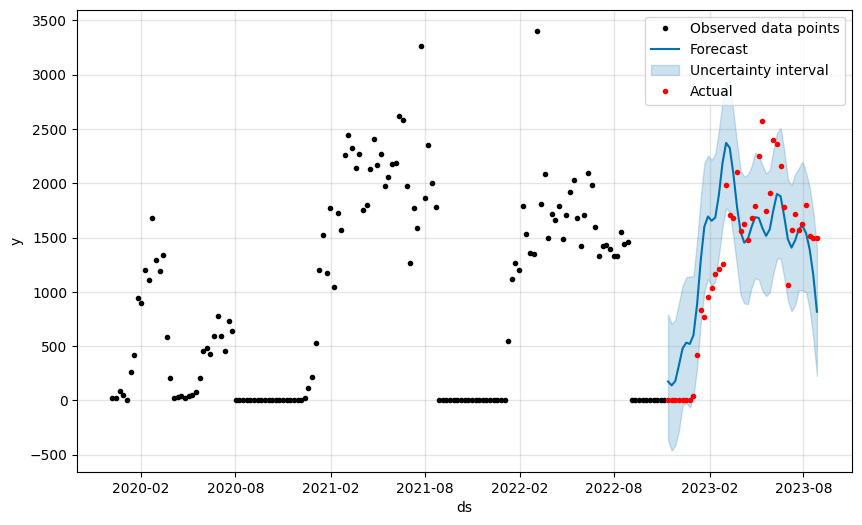

/var/folders/4n/7zm_f9b959gbsyh_5ld2nw_80000gn/T/ipykernel_4598/3979170457.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_trial['year_week'] = df_trial['year_week'].apply(yearweek_to_datetime)


Mean Absolute Error (MAE): 383.36
Mean Squared Error (MSE): 211590.79
Root Mean Squared Error (RMSE): 459.99
Symmetric Mean Absolute Percentage Error (SMAPE): 58.40%
WMAPE: 29.67%
Total Aboslute Percentage Error: 7.24% 

********************
EA
NORAME
N1
********************


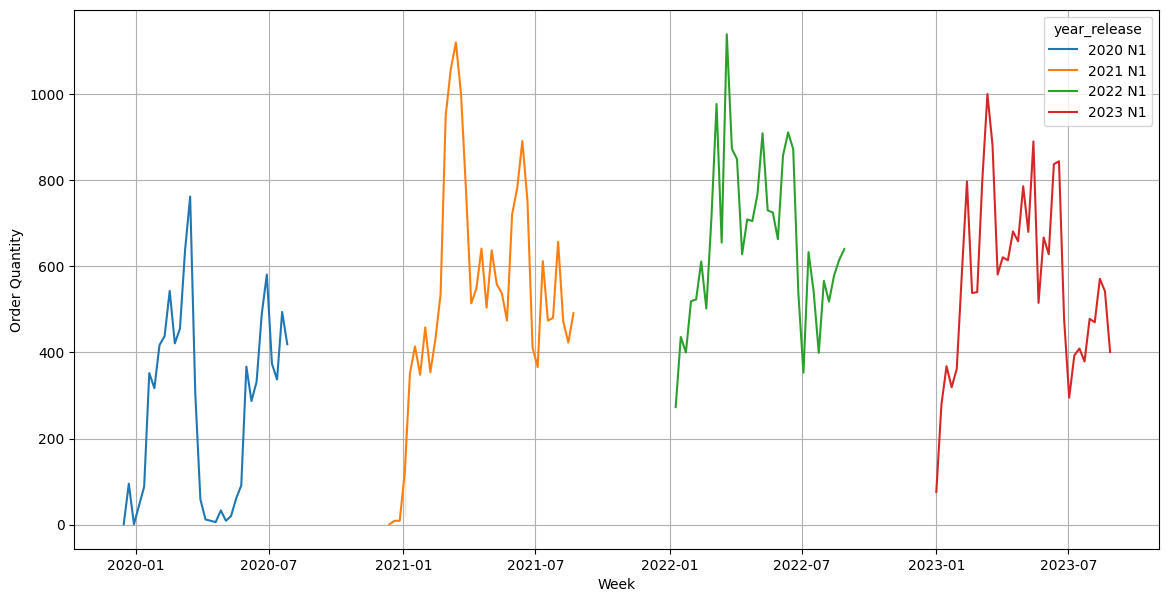

22:39:26 - cmdstanpy - INFO - Chain [1] start processing
22:39:26 - cmdstanpy - INFO - Chain [1] done processing
/Users/mottad/Library/CloudStorage/OneDrive-LuxotticaGroupS.p.A/Desktop/tesi_tommy/.venv/lib/python3.11/site-packages/prophet/plot.py:72: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  fcst_t = fcst['ds'].dt.to_pydatetime()
/Users/mottad/Library/CloudStorage/OneDrive-LuxotticaGroupS.p.A/Desktop/tesi_tommy/.venv/lib/python3.11/site-packages/prophet/plot.py:73: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  ax.plot(m.history['ds'].dt.to_pydatetime(), m.history['y'], 'k.',


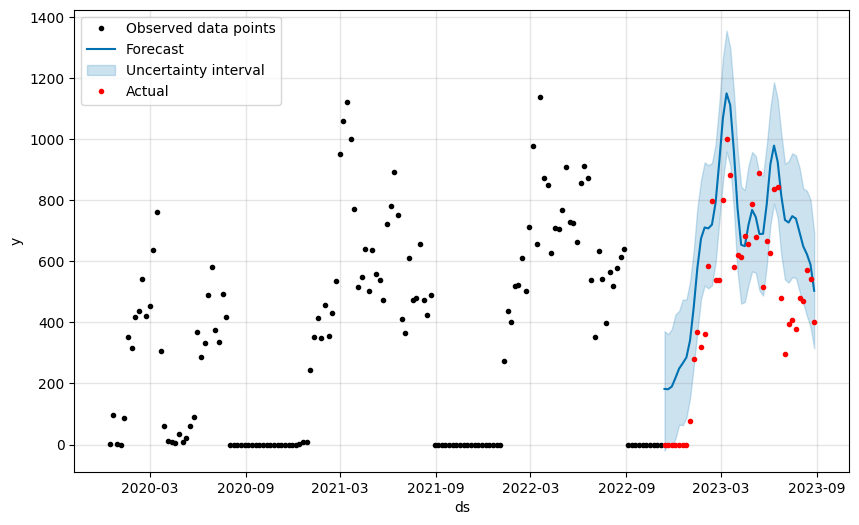

/var/folders/4n/7zm_f9b959gbsyh_5ld2nw_80000gn/T/ipykernel_4598/3979170457.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_trial['year_week'] = df_trial['year_week'].apply(yearweek_to_datetime)


Mean Absolute Error (MAE): 203.96
Mean Squared Error (MSE): 53937.21
Root Mean Squared Error (RMSE): 232.24
Symmetric Mean Absolute Percentage Error (SMAPE): 62.01%
WMAPE: 42.91%
Total Aboslute Percentage Error: 39.63% 

********************
DG
NORAME
N1
********************


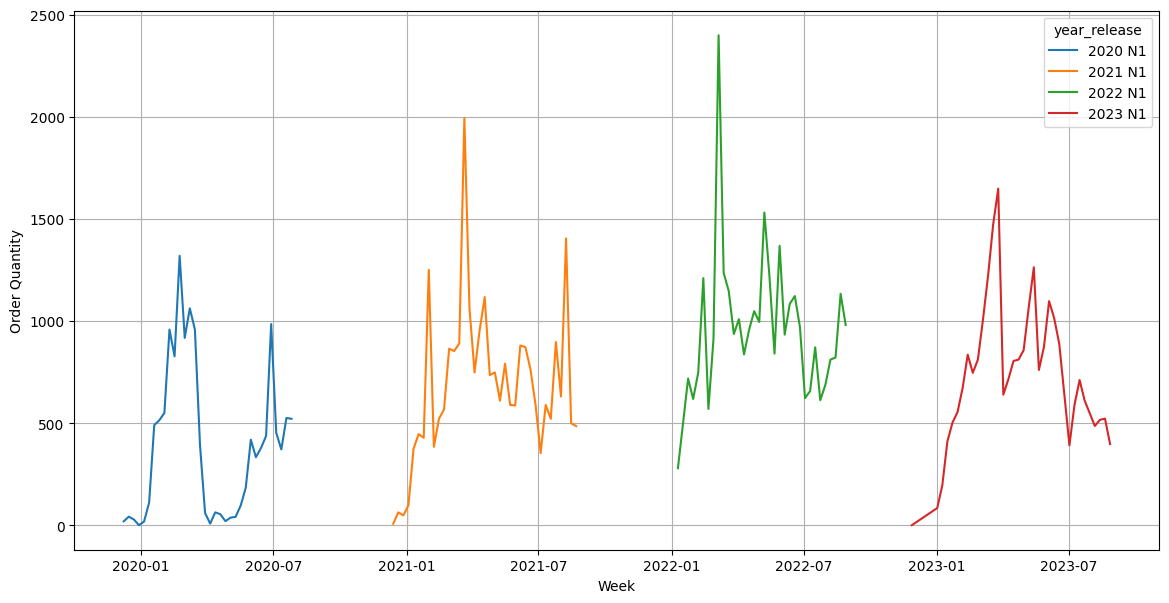

22:39:26 - cmdstanpy - INFO - Chain [1] start processing
22:39:26 - cmdstanpy - INFO - Chain [1] done processing
/Users/mottad/Library/CloudStorage/OneDrive-LuxotticaGroupS.p.A/Desktop/tesi_tommy/.venv/lib/python3.11/site-packages/prophet/plot.py:72: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  fcst_t = fcst['ds'].dt.to_pydatetime()
/Users/mottad/Library/CloudStorage/OneDrive-LuxotticaGroupS.p.A/Desktop/tesi_tommy/.venv/lib/python3.11/site-packages/prophet/plot.py:73: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  ax.plot(m.history['ds'].dt.to_pydatetime(), m.history['y'], 'k.',


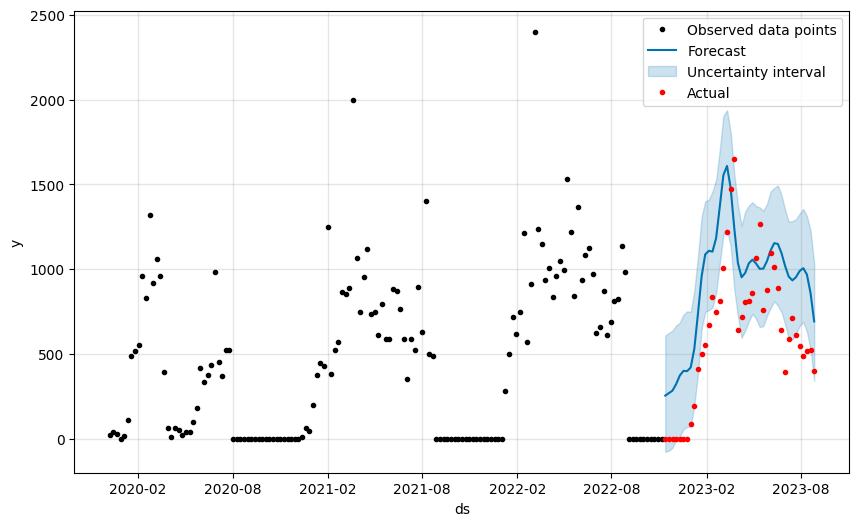

Mean Absolute Error (MAE): 326.93
Mean Squared Error (MSE): 126671.94
Root Mean Squared Error (RMSE): 355.91
Symmetric Mean Absolute Percentage Error (SMAPE): 68.55%
WMAPE: 52.02%
Total Aboslute Percentage Error: 46.70% 



In [21]:
for brand in ['RB','OO','RX','VO','PR','EA','DG']:

    brand = brand
    area = AREA
    release = RELEASE

    print("*"*20)
    print(brand)
    print(area)
    print(release)
    print("*"*20)
    df_trial = df_temp.query("brand == @brand and area_dedalo == @area and release == @release")

    df_trial['year_week'] = df_trial['year_week'].apply(yearweek_to_datetime)

    df_filtered = df_trial[df_trial.apply(filter_dates, axis=1)]


    df_plot = df_filtered.copy()
    # Set the 'year_week' column as the DataFrame index

    df_filtered = df_filtered.groupby(by = 'year_week', as_index=False)['order_quantity'].sum()
    df_ts = df_filtered.set_index('year_week')


    # Resample the data to have a weekly frequency
    df_weekly = df_ts['order_quantity'].resample('W').sum()

    # Now plot the time series


    plt.figure(figsize=(14, 7))
    sns.lineplot(data = df_plot,  x = 'year_week', y = 'order_quantity', hue = 'year_release')
    plt.xlabel('Week')
    plt.ylabel('Order Quantity')
    plt.grid(True)
    plt.show()





    # Split the data into a training set and a testing set
    train_size = int(len(df_weekly) * 0.785)
    train = df_weekly.iloc[:train_size].reset_index().rename(columns={'year_week': 'ds', 'order_quantity': 'y'})
    test = df_weekly.iloc[train_size:].reset_index().rename(columns={'year_week': 'ds', 'order_quantity': 'y'})

    # Initialize the Prophet model
    model = Prophet()

    # Fit the model with the training set
    model.fit(train)

    # Create a DataFrame with future dates for forecasting based on the testing set
    future = test.drop(columns='y')

    # Make predictions on the testing set dates
    forecast = model.predict(future)

    # Plot the forecast and the actual values
    fig, ax = plt.subplots(figsize=(10, 6))
    model.plot(forecast, ax=ax)
    ax.plot(test['ds'], test['y'], 'r.', label='Actual')
    plt.legend()
    plt.show()

    # Calculate performance metrics
    test['forecast'] = forecast['yhat'].values
    mae = mean_absolute_error(test['y'], test['forecast'])
    mse = mean_squared_error(test['y'], test['forecast'])
    rmse = sqrt(mse)
    wmape_val = wmape(test['y'], test['forecast'])
    smape_value = smape(test['y'], test['forecast'])

    print(f'Mean Absolute Error (MAE): {mae:.2f}')
    print(f'Mean Squared Error (MSE): {mse:.2f}')
    print(f'Root Mean Squared Error (RMSE): {rmse:.2f}')
    print(f'Symmetric Mean Absolute Percentage Error (SMAPE): {smape_value:.2f}%')
    print(f'WMAPE: {wmape_val:.2f}%')
    print(f'Total Aboslute Percentage Error: {(np.abs(test.forecast.sum() - test.y.sum())/test.y.sum())*100:.2f}% ')

    print()